In [1]:
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
from astropy.io import fits

In [3]:
from astropy.coordinates import SkyCoord

In [4]:
import astropy.wcs.wcs as wcs
import matplotlib.pyplot as plt

In [5]:
from collections import OrderedDict
from DataScienceToolBox import preprocessing as prep

In [6]:
from IPython.display import Image

# Initialize data directory

In [7]:
path = "../../Data/"
dataPath = path + "Subaru_data/"

## load combined cat

In [8]:
df = pd.read_hdf(dataPath + "combined_cat.h5", 
                 "preprocess_df")

## Location of bright star?

In [9]:
bands = [k for k in df.keys() if "_MAG_" in k]

In [10]:
brightstar = df["Iband_MAG_ISO"].argmin()

In [11]:
df[bands].ix[brightstar]

Rband_MAG_ISO     13.004297
Rband_MAG_APER    18.930527
Rband_MAG_AUTO    12.784573
Iband_MAG_ISO     13.233079
Iband_MAG_APER    18.941272
Iband_MAG_AUTO    12.964162
Gband_MAG_ISO     12.993135
Gband_MAG_APER    17.826713
Gband_MAG_AUTO    12.529636
Name: 48579, dtype: float64

In [12]:
print df.loc[brightstar].RA, df.loc[brightstar].DEC

268.06539917 44.6687393188


approximately true 

# Signal to noise cut

In [13]:
for i in ["R", "G", "I"]:
    for bandtype in ["ISO", "AUTO", "APER"]: 
        SNRkey = "{0}band_{1}_SNR".format(i, bandtype)
        bandkey = "{0}band_MAG_{1}".format(i, bandtype)
        banderrkey = "{0}band_MAGERR_{1}".format(i, bandtype)
        df[SNRkey] = \
            np.abs(df[bandkey] / df[banderrkey])

# Subaru data cuts

5 $\sigma$ limiting magnitude of this Subaru catalog ...

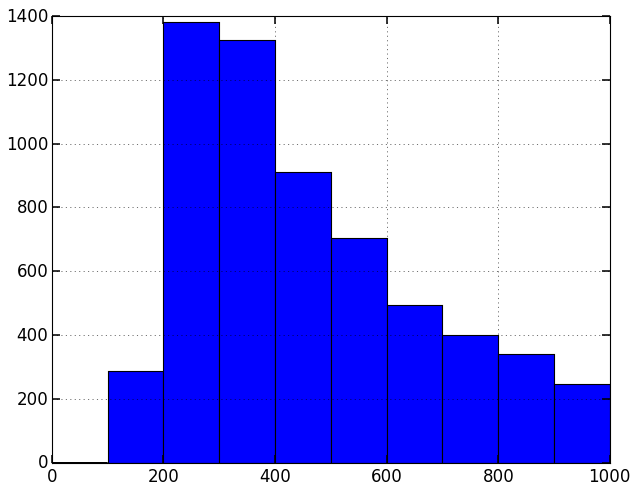

In [23]:
df["Rband_ISO_SNR"].hist(range= (0, 1000))

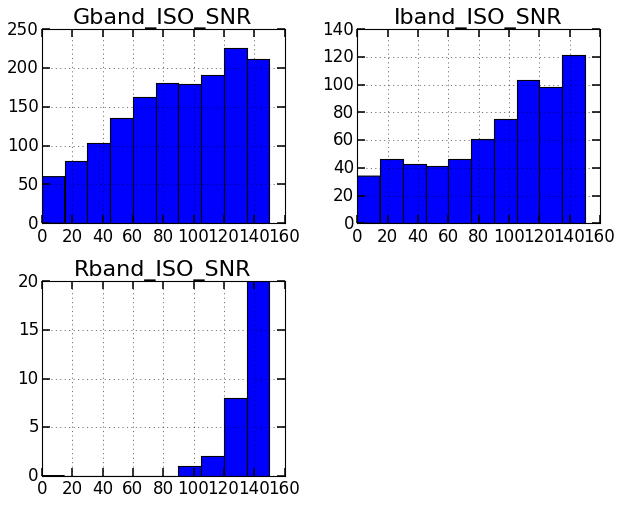

In [240]:
keys = ["Rband_ISO_SNR", "Iband_ISO_SNR", "Gband_ISO_SNR"] 
_ = df[keys].hist(range=(0, 150))

# come up with cuts for the shape catalog 

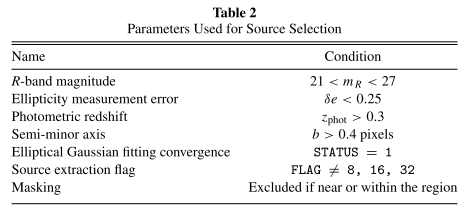

In [14]:
Image("./cut_range.png")  # from Jee 2013 Cosmic Shear paper

In [37]:
# format is key: (lower_bound, upperbound) 
# bounds are inclusive
accepted_range = {"Rband_MAG_ISO": (21, 25),
                  "Rband_MAG_AUTO": (21, 25),
                  "DE": (0, 0.25),
                  "Rband_B_IMAGE": (0.4, None),
                  "Iband_CLASS_STAR": (None, 0.6),
                  "Iband_FLUX_RADIUS": (2.3, None),
                  "Iband_ISO_SNR": (5, None),
                  "Iband_AUTO_SNR": (5, None),
                  "Iband_APER_SNR": (5, None)
                 }
accepted_cat = {"STATUS": 1}
rej_cat = {k: (8, 16, 32) for k in df.keys() if "FLAG" in k}


In [38]:
mask = prep.process_cuts(df, arange=accepted_range,
                  accept_cat=accepted_cat,
                  categorical_cuts=rej_cat,
                  verbose=True)

accepted obs with Rband_MAG_ISO_low >= 21 is 8391, 94.37% remaining
accepted obs with  Rband_MAG_ISO_up <= 25 is 3465, 38.97% remaining
accepted obs with Iband_APER_SNR_low >= 5 is 8696, 97.80% remaining
accepted obs with  Iband_CLASS_STAR_up <= 0.6 is 7634, 85.85% remaining
accepted obs with Rband_MAG_AUTO_low >= 21 is 8299, 93.33% remaining
accepted obs with  Rband_MAG_AUTO_up <= 25 is 3919, 44.07% remaining
accepted obs with Rband_B_IMAGE_low >= 0.4 is 8891, 99.99% remaining
accepted obs with Iband_ISO_SNR_low >= 5 is 8712, 97.98% remaining
accepted obs with Iband_FLUX_RADIUS_low >= 2.3 is 5534, 62.24% remaining
accepted obs with DE_low >= 0 is 8892, 100.00% remaining
accepted obs with  DE_up <= 0.25 is 4888, 54.97% remaining
accepted obs with Iband_AUTO_SNR_low >= 5 is 8576, 96.45% remaining
obs only accepting STATUS == 1 is 7372, 82.91% remaining
obs after cutting Rband_FLAGS != (8, 16, 32) is 8892, 100.00% remaining
obs after cutting Iband_FLAGS != (8, 16, 32) is 8885, 99.92% rem

In [39]:
star_class_keys = [u"{}band_CLASS_STAR".format(k) 
                   for k in ["I", "G", "R"]]
star_mask = df[star_class_keys] > 0.6
semiminor_key = [k for k in df.keys() if "B_IMAGE" in k]
semiminor_mask = df[semiminor_key] < 0.4

# Visualize different cuts

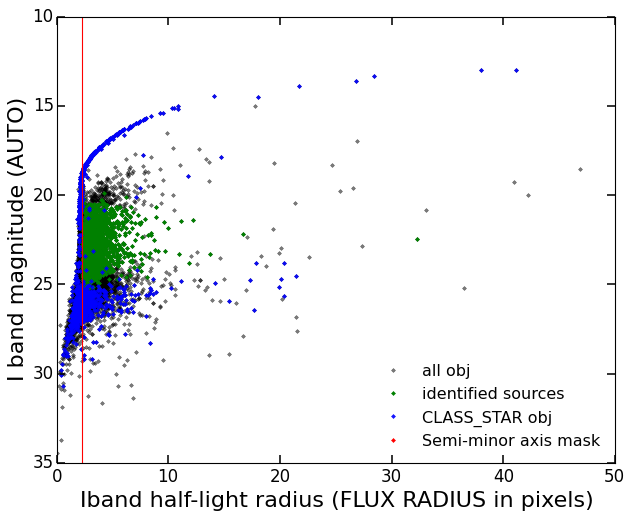

In [45]:
plt.plot(df["Iband_FLUX_RADIUS"],
         df["Iband_MAG_AUTO"],
         'k.', alpha=.5, label="all obj")
plt.plot(df["Iband_FLUX_RADIUS"][mask],
         df["Iband_MAG_AUTO"][mask],
         'g.', label="identified sources")

# SEXtractor actually nails the stellar locus
plt.plot(df["Iband_FLUX_RADIUS"][star_mask["Iband_CLASS_STAR"]],
         df["Iband_MAG_AUTO"][star_mask["Iband_CLASS_STAR"]],
         'b.', alpha=.9, label="CLASS_STAR obj")
plt.plot(df["Iband_FLUX_RADIUS"][semiminor_mask["Iband_B_IMAGE"]],
         df["Iband_MAG_AUTO"][semiminor_mask["Iband_B_IMAGE"]],
         'r.', label="Semi-minor axis mask")

plt.axvline(2.3, color='r', label="pi")
plt.xlim(0, 50)
plt.ylim(plt.ylim()[::-1])
plt.legend(loc='best')
plt.ylabel("I band magnitude (AUTO)")
plt.xlabel("Iband half-light radius (FLUX RADIUS in pixels)")

# Determining star halflight radius cutoff

In [253]:
starlocus_mask = np.logical_and(df["Iband_MAG_AUTO"] <= 19,
                                star_mask["Iband_CLASS_STAR"])
FLUX_RADIUS_lower_cutoff = \
    df["Iband_FLUX_RADIUS"][starlocus_mask].ix[68119]

In [256]:
print FLUX_RADIUS_lower_cutoff

2.24178814888


(35.0, 10.0)

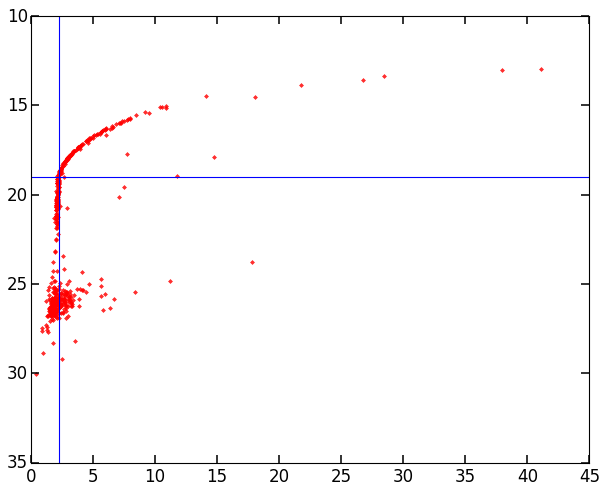

In [254]:
plt.plot(df["Iband_FLUX_RADIUS"][star_mask["Iband_CLASS_STAR"]],
         df["Iband_MAG_AUTO"][star_mask["Iband_CLASS_STAR"]],
         'r.', alpha=.8, label="CLASS_STAR obj")
plt.axvline(FLUX_RADIUS_lower_cutoff)
plt.axhline(19)
plt.ylim(plt.ylim()[::-1])